# Explore the all_speeches.csv dataset

# 1. Initial exploration and cleaning

## 1a. Library and package import, exploration

In [1]:
# Import all the necessary packages and libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install langdetect
from langdetect import detect, LangDetectException

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

!pip install wordcloud
from wordcloud import WordCloud

In [2]:
# Load the CSV file into a DataFrame
speech = pd.read_csv('all_speeches.csv', sep=',')

# Display the first five rows of the DataFrame
print(speech.head())

      reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  
0  fraser       0  They would no doubt argue that to have two obj...  
1  fraser       0  Today I wish to talk about real interest rates...  
2  fraser       0  I welcome this opportunity to talk about prosp...  
3  fraser       0  It is a pleasure to have this opportunity to a...  
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...  


### Check characteristics of dataset

In [3]:
# Understand the characteristics of the dataset
speech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reference  7721 non-null   object
 1   country    7721 non-null   object
 2   date       7721 non-null   object
 3   title      7721 non-null   object
 4   author     7721 non-null   object
 5   is_gov     7721 non-null   int64 
 6   text       7721 non-null   object
dtypes: int64(1), object(6)
memory usage: 422.4+ KB


There are 7721 speeches, with 6 columns. All are in 'object' format datatype, with the exception of 'is_gov'. 

See below our views on the most appropriate datatypes for each clolumn:

- **reference**: Object is best, as the reference is an alphanumeric ID. 
- **country**: Object is best, as country names are text data. 
- **date**: This is currently stored as 'object' but should be converted to 'datetime64' to take advantage of pandas' time series functionalities. 
- **title**: Titles are textual content, so they are best stored as object (string) data types.
- **author**: Same as above
- **is_gov**: This looks to be a binary dataset. This could be converted into a bool datatype, however we must make sure that the data is clean before converting. We shall check for any missing values before converting. 
- **text**: As this contains long textual data, 'object' datatype is the most appropriate for handling paragraphs of text. 


### Check all reference IDs are unique

The 'reference' column will be a good identifier for analysis, we shall check if there are any duplicate values in this column, or if it is all unique. 

In [4]:
# Check for duplicate values in the 'reference' column
duplicate_references = speech['reference'].duplicated()

# Count the number of duplicate values
num_duplicates = duplicate_references.sum()

# Print the count of duplicate 'reference' values
print(f"Number of duplicate values in the 'reference' column: {num_duplicates}")

Number of duplicate values in the 'reference' column: 0


There are no duplicate values in the 'reference' column. We can proceed.

## 1b. Cleaning of data

### Convert 'date' column to datetime format

In [5]:
# Create a new copy of the DataFrame
speech_2 = speech.copy()

# Convert the 'date' column to datetime format, coercing errors to NaT
speech_2['date'] = pd.to_datetime(speech_2['date'], errors='coerce')

In [6]:
# Count how many NaT values are in the 'date' column of speech_2
nat_count = speech_2['date'].isna().sum()

# Display the count
print(f"Number of NaT values in the 'date' column: {nat_count}")

Number of NaT values in the 'date' column: 0


There were no values in the 'date' column that was not a 'datetime' data format to be appropriately converted. 

To understand how many null cells there are in the dataset, it is important to first remove any leading or trailing spaces from each column (except for the date column, which we have converted and have confidence it contains datetime format data only). This will allow us to identify all 'true' null cells and get an accurate overview.

### Remove leading/trailing spaces from columns where datatype is 'object', identify null cells

In [7]:
# Create a new copy of the DataFrame
speech_3 = speech_2.copy()

# Iterate over each column in the DataFrame
for col in speech_3.columns:
    # Skip the 'date' column
    if col != 'date':
        # Check if the column's data type is 'object' (string)
        if speech_3[col].dtype == 'object':
            # Remove leading and trailing spaces
            speech_3[col] = speech_3[col].str.strip()

In [8]:
# Replace cells in the 'title' column that are only spaces with NaN
speech_3['title'] = speech_3['title'].replace(r'^\s*$', np.nan, regex=True)

In [9]:
# Count the number of null cells in each column
null_counts = speech_3.isna().sum()

# Display the count of null cells for each column
print(null_counts)

reference      0
country        0
date           0
title        181
author         0
is_gov         0
text           0
dtype: int64


There are 181 entries in the 'Title' column that are blank. These will be replaced with "NO_TITLE". There are also currently entries of "NO_INFO" in this column. These will also be converted to "NO_TITLE".

We now have assurance that there are no null cells in each column, and continue on with our cleaning process.

### Rename null cells appropriately

In [10]:
# Create a new copy of the DataFrame
speech_4 = speech_3.copy()

# Replace NaN values in the 'Title' column with "NO_TITLE"
speech_4['title'] = speech_3['title'].fillna("NO_TITLE")

In [11]:
# Replace "NO_INFO" with "NO_TITLE" in the 'title' column
speech_4['title'] = speech_4['title'].replace("NO_INFO", "NO_TITLE")

In [12]:
# Save the DataFrame to a CSV file
speech_4.to_csv('speech_4.csv', index=False)

### Convert 'is_gov' column to a boolean data type

In [13]:
# Create a new copy of the DataFrame
speech_5 = speech_4.copy()

# Convert 'is_gov' to boolean
speech_5['is_gov'] = speech_5['is_gov'].astype(bool)

In [14]:
# Save the DataFrame to a CSV file
speech_5.to_csv('speech_5.csv', index=False)

### Capitalise the contents of the 'Country' and 'Author' column for readability

In [15]:
# Create a new copy of the DataFrame
speech_6 = speech_5.copy()

# Capitalize each word in the 'Country' column
speech_6['country'] = speech_6['country'].str.title()
speech_6['author'] = speech_6['author'].str.title()

In [16]:
# Save the DataFrame to a CSV file
speech_6.to_csv('speech_6.csv', index=False)

# 2. Initial summarisation of data

### Step 1: Summarise dataframe to show the array of countries, and authors present in the dataset

In [17]:
# Columns to exclude from the summary
exclude_columns = ['reference','date', 'text', 'title']

# Initialize an empty dictionary to store the unique values
unique_values_dict = {}

# Iterate over the DataFrame columns, excluding the specified ones
for col in speech_6.columns:
    if col not in exclude_columns:
        # Get unique values in the column and store them in the dictionary
        unique_values_dict[col] = [speech_6[col].unique()]

# Convert the dictionary to a DataFrame
unique_values_df = pd.DataFrame.from_dict(unique_values_dict, orient='index', columns=['Unique Values'])

# Transpose the DataFrame to have column names at the top and unique values list below
unique_values_df = unique_values_df.transpose()

# Display the DataFrame
print(unique_values_df)

                                                         country  \
Unique Values  [Australia, Canada, Euro Area, Japan, Sweden, ...   

                                                          author  \
Unique Values  [Fraser, Macfarlane, Lowe, Stevens, No_Info, A...   

                      is_gov  
Unique Values  [False, True]  


In [18]:
# Create an empty DataFrame for the expanded lists
expanded_df = pd.DataFrame()

for col in unique_values_df.columns:
    # Expand each list into a series, then transpose so each value becomes a column
    expanded_series = pd.Series(unique_values_df[col].iloc[0]).reset_index(drop=True)
    # Assign the expanded series to expanded_df with a column prefix
    expanded_df = pd.concat([expanded_df, expanded_series.rename(lambda x: f"{col}_{x}")], axis=1)

# Now, 'expanded_df' has each element in separate cells
# Save the expanded DataFrame to a CSV
expanded_df.to_csv('expanded_unique_values.csv', index=False)

After reviewing the unique values, we can see there are authors with '[' as the name. We will review this further to understand what the speech relates to

#### Investigate and correct clearly erroneous author name 

In [19]:
# Filter the DataFrame for rows where the author column equals ']'
specific_author_rows = speech_6[speech_6['author'] == ']']

# Display the entire rows that meet the condition
print(specific_author_rows)

         reference    country       date  \
2813  r180409a_ECB  Euro Area 2018-04-09   

                                       title author  is_gov  \
2813  Economic developments in the euro area      ]   False   

                                                   text  
2813  The economic expansion clearly shows that our ...  


It is apparent that this author ']' in in fact Praet. This will be corrected for the purpose of analysis. 


Source for confirmation: https://www.bis.org/review/r180410c.htm

In [20]:
# Create a new copy of the DataFrame
speech_7 = speech_6.copy()

# Replace author ']' with 'Praet'
speech_7['author'] = speech_7['author'].replace(']', 'Praet')

### Step 2: Summarise dataframe to show the array of countries, and authors present in the dataset (post-correction)

In [21]:
# Specify columns to exclude from the summary
exclude_columns = ['reference','date', 'text', 'title']

# Initialize an empty dictionary to store the unique values
unique_values_dict_2 = {}

# Iterate over the DataFrame columns, excluding the specified ones
for col in speech_6.columns:
    if col not in exclude_columns:
        # Get unique values in the column and store them in the dictionary
        unique_values_dict_2[col] = [speech_7[col].unique()]

# Convert the dictionary to a DataFrame
unique_values_df_2 = pd.DataFrame.from_dict(unique_values_dict_2, orient='index', columns=['Unique Values'])

# Transpose the DataFrame to have column names at the top and unique values list below
unique_values_df_2 = unique_values_df_2.transpose()

# Display the DataFrame
print(unique_values_df_2)

                                                         country  \
Unique Values  [Australia, Canada, Euro Area, Japan, Sweden, ...   

                                                          author  \
Unique Values  [Fraser, Macfarlane, Lowe, Stevens, No_Info, A...   

                      is_gov  
Unique Values  [False, True]  


In [22]:
# Create an empty DataFrame for the expanded lists
expanded_df_2 = pd.DataFrame()

for col in unique_values_df.columns:
    # Expand each list into a series, then transpose so each value becomes a column
    expanded_series_2 = pd.Series(unique_values_df_2[col].iloc[0]).reset_index(drop=True)
    # Assign the expanded series to expanded_df with a column prefix
    expanded_df_2 = pd.concat([expanded_df_2, expanded_series_2.rename(lambda x: f"{col}_{x}")], axis=1)

# Now, 'expanded_df' has each element in separate cells
# Save the expanded DataFrame to a CSV
expanded_df_2.to_csv('expanded_unique_values_2.csv', index=False)

### Step 3: Additional data enhancement - Create new column showing name of central bank, both abbreviated and full name

In [23]:
# Create a new copy of the DataFrame
speech_8 = speech_7.copy()

# Split the 'reference' column on '_' and take the last part
speech_8['Body'] = speech_8['reference'].str.split('_').str[-1]


In [24]:
# Save dataframe as csv
speech_8.to_csv('speech_8.csv', index=False)

In [25]:
# Get all unique values in the 'Body' column
unique_bodies = speech_8['Body'].unique()

# Display the unique values
print(unique_bodies)

['BOA' 'BOC' 'ECB' 'BOJ' 'SRB' 'SNB' 'BOE' 'FOMC']


In [26]:
# Create a new copy of the DataFrame
speech_9 = speech_8.copy()

body_to_bank = {
    'BOA': 'Bank of Australia',
    'BOC': 'Bank of Canada',
    'ECB': 'European Central Bank',
    'BOJ': 'Bank of Japan',
    'SRB': 'Central Bank of Sweden',
    'SNB': 'Swiss National Bank',
    'BOE': 'Bank of England',
    'FOMC': 'Federal Open Market Committee'
}

# Map the 'Body' abbreviations to their full names using the dictionary
speech_9['central_bank'] = speech_9['Body'].map(body_to_bank)


In [27]:
# Save dataframe as csv
speech_9.to_csv('speech_9.csv', index=False)

# 3. Visualise the data

## 3a. Visualise the frequency of speeches over time (by Central bank)

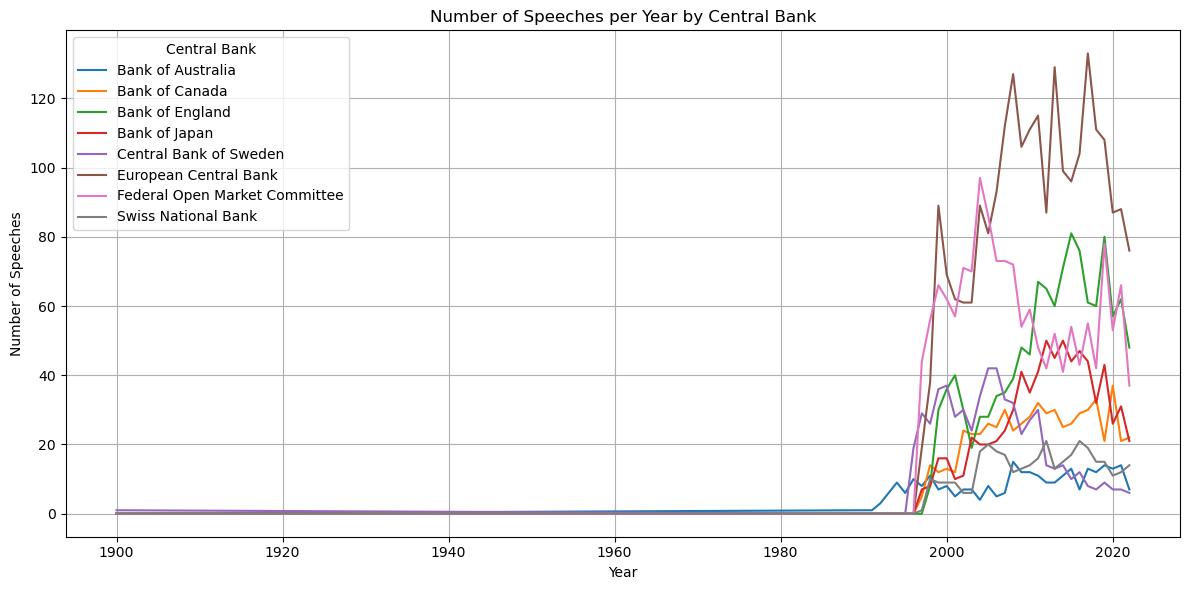

In [28]:
# Create a new copy of the DataFrame
speech_10 = speech_9.copy()


# First, extract the year from the 'date' column
speech_10['year'] = speech_10['date'].dt.year

# Next, group by 'year' and 'central_bank' and count the number of speeches
speech_count_by_year = speech_10.groupby(['year', 'central_bank']).size().reset_index(name='speech_count')

# Pivot the DataFrame to have years on the index, central banks as columns, and speech counts as values
pivot_table = speech_count_by_year.pivot(index='year', columns='central_bank', values='speech_count').fillna(0)

# Plot the data
plt.figure(figsize=(12, 6))
for central_bank in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[central_bank], marker='', label=central_bank)

# Customizing the plot
plt.title('Number of Speeches per Year by Central Bank')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.legend(title='Central Bank')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

## 3b. Visualise the frequency of speeches over time (by Central bank, between 1992 - 2022)

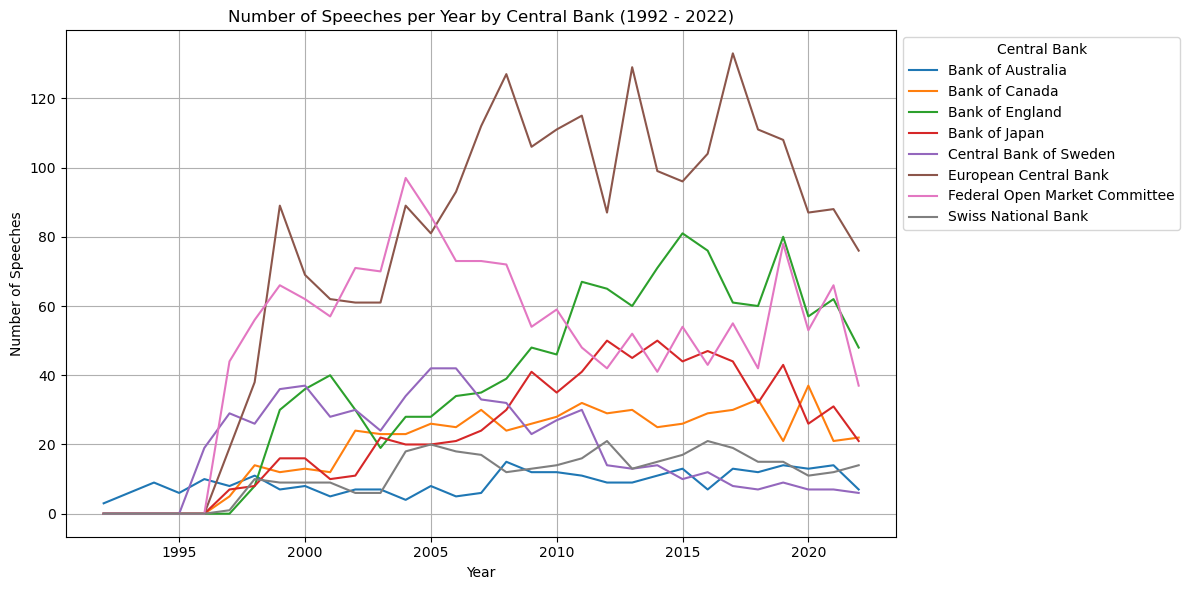

In [29]:
# Extract the year from the 'date' column
speech_10['year'] = speech_10['date'].dt.year

# Group by 'year' and 'central_bank' and count the number of speeches
speech_count_by_year = speech_10.groupby(['year', 'central_bank']).size().reset_index(name='speech_count')

# Pivot the DataFrame
pivot_table = speech_count_by_year.pivot(index='year', columns='central_bank', values='speech_count').fillna(0)

# Filter the DataFrame to include only the years from 1992 to 2022 inclusive
pivot_table_filtered = pivot_table.loc[1992:2022]

# Plot the data for the filtered years
plt.figure(figsize=(12, 6))
for central_bank in pivot_table_filtered.columns:
    plt.plot(pivot_table_filtered.index, pivot_table_filtered[central_bank], marker='', label=central_bank)

# Customizing the plot
plt.title('Number of Speeches per Year by Central Bank (1992 - 2022)')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.legend(title='Central Bank', loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend position
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

## 3c. Visualise the frequency of speeches over time (by Central bank) in a table

In [30]:
# Extract the year from the 'date' column
speech_10['year'] = speech_10['date'].dt.year

# Group by 'year' and 'central_bank' and count the number of speeches
speech_count_by_year = speech_10.groupby(['central_bank', 'year']).size().reset_index(name='frequency')

# Create a pivot table with 'central_bank' as rows, 'year' as columns, and 'frequency' as values
frequency_table = speech_count_by_year.pivot(index='central_bank', columns='year', values='frequency').fillna(0)

# Convert the years to integer type to avoid floating-point representation of years
frequency_table.columns = frequency_table.columns.astype(int)

# Display the frequency table
print(frequency_table)

year                           1900  1990  1991  1992  1993  1994  1995  1996  \
central_bank                                                                    
Bank of Australia               0.0   1.0   1.0   3.0   6.0   9.0   6.0  10.0   
Bank of Canada                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Bank of England                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Bank of Japan                   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Central Bank of Sweden          1.0   0.0   0.0   0.0   0.0   0.0   0.0  19.0   
European Central Bank           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Federal Open Market Committee   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Swiss National Bank             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

year                           1997  1998  ...   2013  2014  2015   2016  \
central_bank                               ...                             
Bank of Australia               8.0  

In [31]:
# Save the DataFrame to a CSV file
frequency_table.to_csv('speech_by_year.csv', index=True)

## 3d. Visualise the frequency of speeches over time (by author at BOE) in a graph

/var/folders/fd/l1j1hff11tl7j02fzwwhq3bh0000gn/T/ipykernel_92239/871307692.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


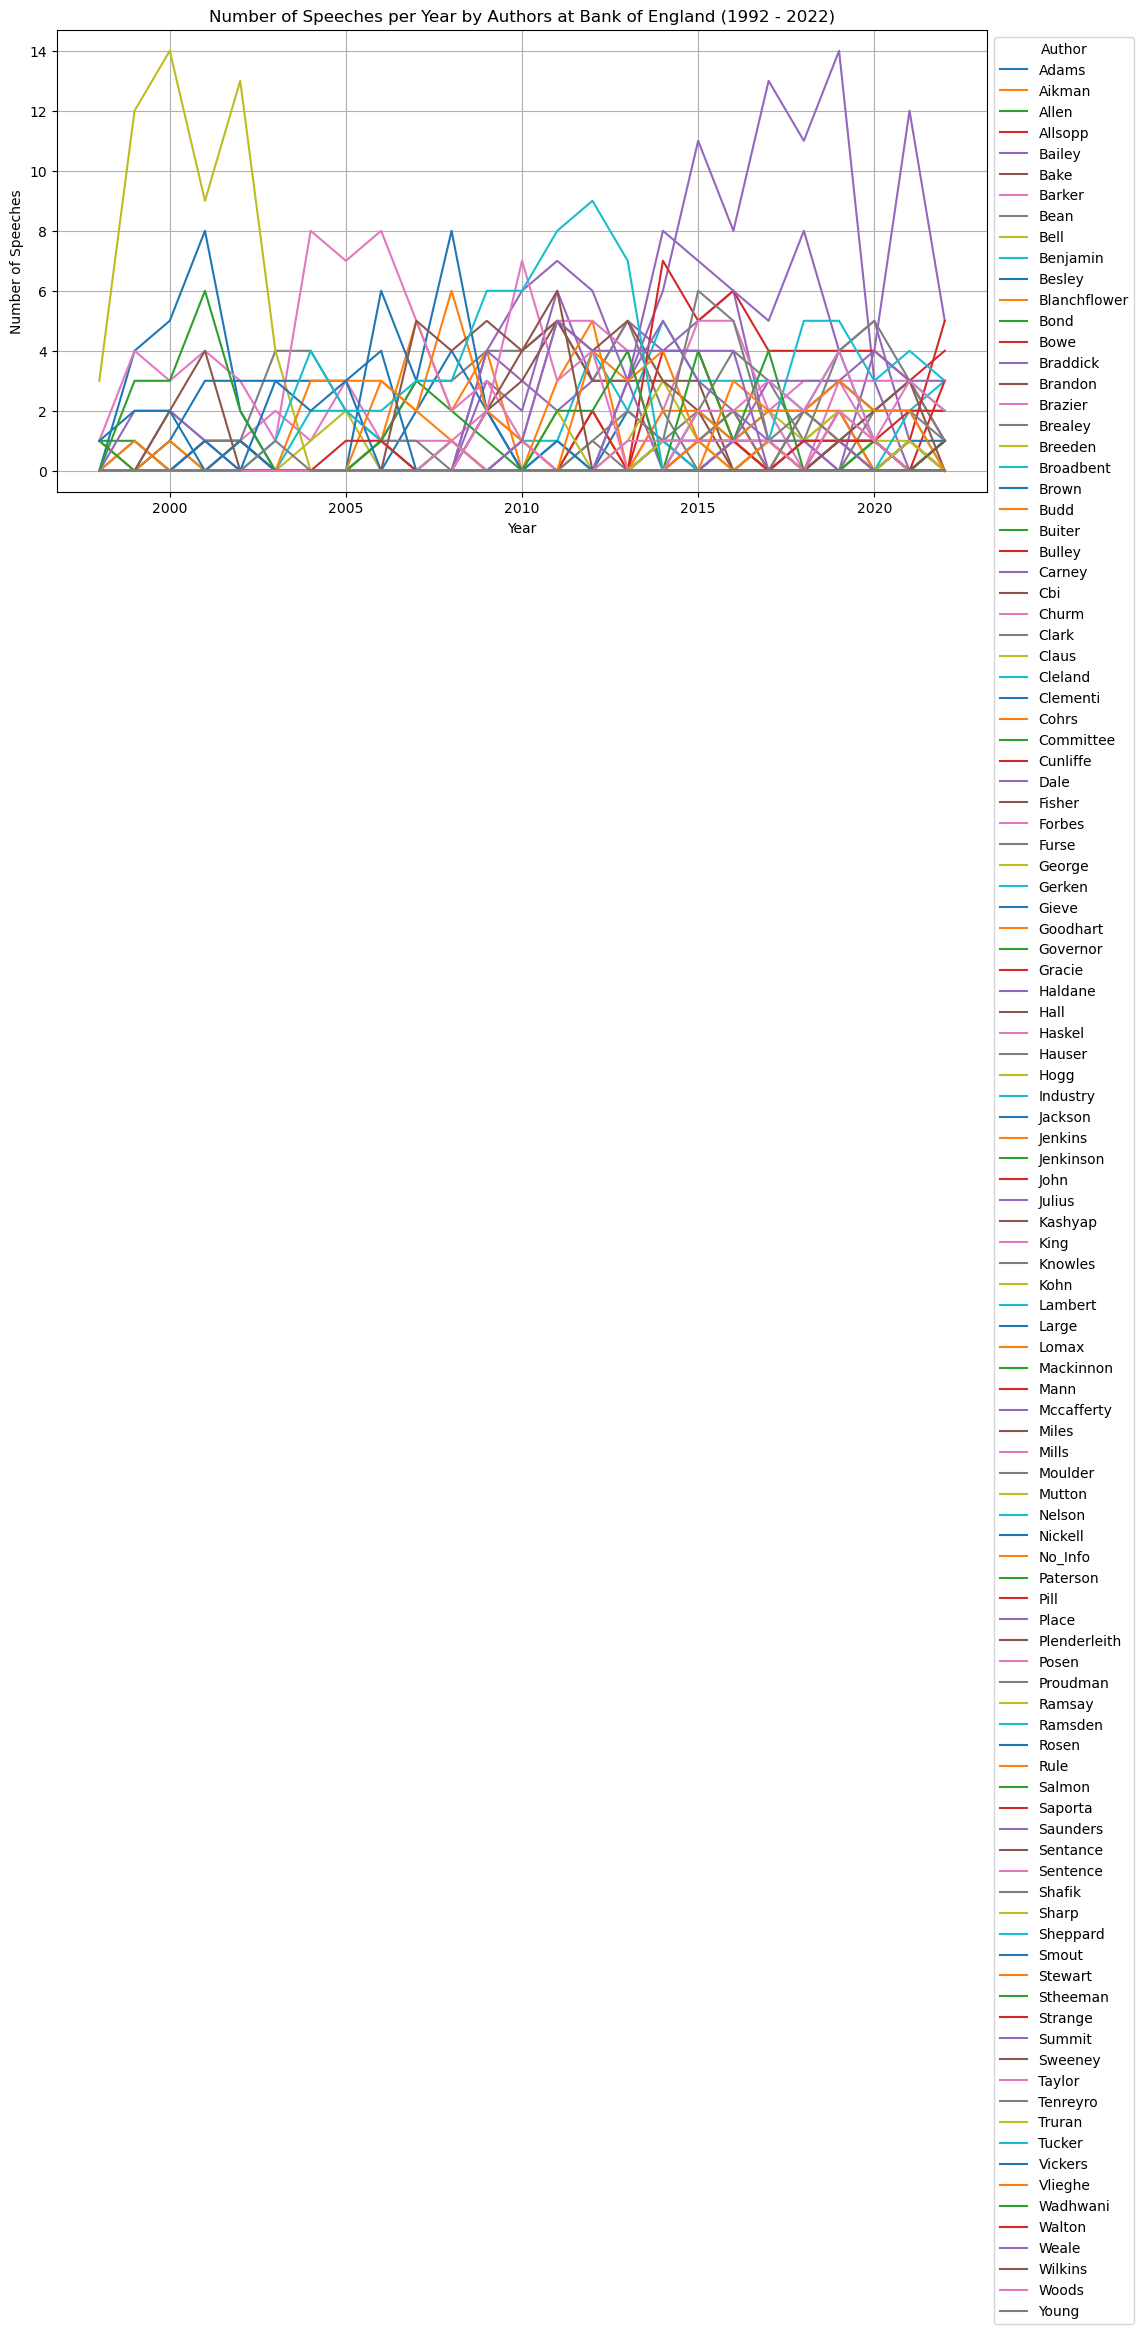

In [32]:
# Extract the year from the 'date' column
speech_10['year'] = speech_10['date'].dt.year

# Filter for Bank of England
boe_speeches = speech_10[speech_10['central_bank'] == 'Bank of England']

# Group by 'year' and 'author' and count the number of speeches
speech_count_by_year_author = boe_speeches.groupby(['year', 'author']).size().reset_index(name='speech_count')

# Pivot the DataFrame
pivot_table = speech_count_by_year_author.pivot(index='year', columns='author', values='speech_count').fillna(0)

# Filter the DataFrame to include only the years from 1992 to 2022 inclusive
pivot_table_filtered = pivot_table.loc[1992:2022]

# Plot the data for the filtered years
plt.figure(figsize=(12, 6))
for author in pivot_table_filtered.columns:
    plt.plot(pivot_table_filtered.index, pivot_table_filtered[author], marker='', label=author)

# Customizing the plot
plt.title('Number of Speeches per Year by Authors at Bank of England (1992 - 2022)')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.legend(title='Author', loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend position
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

We can see there are too many authors in BOE to appropriately visualise all on a graph. This will need to be whittled down in later analysis

### 3e. Create a summary of BoE authors

#### Identify authors at BOE and save as a list in csv

In [33]:
# Filter for Bank of England speeches
boe_speeches = speech_10[speech_10['central_bank'] == 'Bank of England']

# Get unique authors in BOE speeches
unique_boe_authors = boe_speeches['author'].unique()

# Convert the list to a DataFrame
authors_df = pd.DataFrame(unique_boe_authors, columns=['Author'])

# Specify the filename and path where you want to save the CSV
csv_file_path = 'boe_authors.csv'

# Save the DataFrame to a CSV file
authors_df.to_csv(csv_file_path, index=False)

#### Create a list of BOE authors, and show their count of speeches in csv

In [34]:
# Filter for Bank of England speeches
boe_speeches = speech_10[speech_10['central_bank'] == 'Bank of England']

# Count the number of speeches for each author
author_speech_counts = boe_speeches['author'].value_counts()

# Convert the Series to a DataFrame
author_speech_counts_df = author_speech_counts.reset_index()
author_speech_counts_df.columns = ['Author', 'Speech Count']

# Set the 'Author' column as the index
author_speech_counts_df.set_index('Author', inplace=True)

# Save the DataFrame to a CSV file
author_speech_counts_df.to_csv('boe_author_speech_counts.csv', index=True)

# 4. Preparing data for NLP

There are a number of aspects we must keep in mind when preparing text for NLP. Each NLP model will require the text to be prepared in a certain way. However, first there are some checks required that applies to both analysis methods. Language, and removing noise such as urls.

#### 4a. Identify language of speeches to be able to filter for English speeches

In [35]:
# Create a new copy of the DataFrame
speech_11 = speech_10.copy()

# Function to detect language, returns 'unknown' if detection fails
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Apply the language detection function to the 'Text' column
speech_11['language'] = speech_11['text'].apply(detect_language)

# Now, speech_11 has a new column 'Language' with the detected language code for each text entry

# Extract all unique values from the 'Language' column
unique_languages = speech_11['language'].unique()

# Display the unique language codes
print(unique_languages)



['en' 'so' 'it']


In [36]:
# Define the list of language codes we are interested in
languages_of_interest = ['so', 'it']

# Filter the DataFrame for rows where the 'language' column contains 'so' or 'it'
non_eng_speeches = speech_11[speech_11['language'].isin(languages_of_interest)]

# Save the filtered DataFrame to a CSV file
non_eng_speeches.to_csv('non_eng_speeches.csv', index=False)

We can see that there are two speeches that are not in english (one in Italian, and another which looks to be just urls. These will be filtered out when a subset is created for analysis in both uses (Vader, Textblob)

#### 4b. Identify URLs, Hashtags, and mentions present in the dataset

In [37]:
# Check for URLs, hashtags and mentions

# Create a new copy of the DataFrame
speech_12 = speech_11.copy()

# Define regex patterns
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
hashtag_pattern = r'\#[\w\-]+'
mention_pattern = r'\@[\w\-]+'

# Count occurrences
url_count = speech_12['text'].str.contains(url_pattern).sum()
hashtag_count = speech_12['text'].str.contains(hashtag_pattern).sum()
mention_count = speech_12['text'].str.contains(mention_pattern).sum()

print(f"URLs: {url_count}, Hashtags: {hashtag_count}, Mentions: {mention_count}")

URLs: 4, Hashtags: 4, Mentions: 6


In [38]:
# Filter rows where the text contains a URL
speeches_with_urls = speech_12[speech_12['text'].str.contains(url_pattern, na=False)]

# Save as CSV
speeches_with_urls.to_csv('speeches_with_urls.csv', index=False)

In [39]:
# Filter rows where the text contains a hashtag
speeches_with_hashtag = speech_12[speech_12['text'].str.contains(hashtag_pattern, na=False)]

# Save as CSV
speeches_with_hashtag.to_csv('speeches_with_hashtag.csv', index=False)

In [40]:
# Filter rows where the text contains a mention (@)
speeches_with_mention = speech_12[speech_12['text'].str.contains(mention_pattern, na=False)]

# Save as CSV
speeches_with_mention.to_csv('speeches_with_mention.csv', index=False)

Upon review of the output results, the mentions and hashtags do provide context to the text at hand, also there is very little frequency of this happening. Therefore we have kept these characters in as part of the analysis. URLs will be removed. 

##### **Remove URLs from the speech text**

In [41]:
# Regex pattern to match most URLs
url_pattern = r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+|www\.[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,}'

# Initialize an empty list to store information about removed URLs
removed_urls_info = []

# Function to remove URLs from a text string and report back the removed URLs
def remove_urls(text, reference):
    global removed_urls_info
    # Find all URLs in the text
    found_urls = re.findall(url_pattern, text)
    # If URLs are found, store their info
    if found_urls:
        for url in found_urls:
            removed_urls_info.append({'reference': reference, 'removed_url': url})
    # Remove URLs from the text
    cleaned_text = re.sub(url_pattern, '', text)
    return cleaned_text

# Apply the function to the 'text' column to remove URLs and pass the 'reference'
speech_12['clean_text'] = speech_12.apply(lambda x: remove_urls(x['text'], x['reference']), axis=1)

# Display the DataFrame with URLs removed
print(speech_12[['reference', 'clean_text']])

# Print the information about removed URLs
print("Removed URLs Info:")
for info in removed_urls_info:
    print(f"Reference ID: {info['reference']}, Removed URL: {info['removed_url']}")

          reference                                         clean_text
0      r901128a_BOA  They would no doubt argue that to have two obj...
1      r911003a_BOA  Today I wish to talk about real interest rates...
2      r920314a_BOA  I welcome this opportunity to talk about prosp...
3      r920529a_BOA  It is a pleasure to have this opportunity to a...
4      r920817a_BOA  As a long-time fan of Don Sanders, I am deligh...
...             ...                                                ...
7716  r221010a_FOMC  It is a pleasure to join this discussion today...
7717  r221012b_FOMC  Thank you, Chris, and thank you for the invita...
7718  r221012a_FOMC  Thanks to the Money Marketeers for inviting me...
7719  r221014a_FOMC  Thank you, Professor Jackson, and thank you to...
7720  r221020a_FOMC  Welcome, and thank you for joining us to discu...

[7721 rows x 2 columns]
Removed URLs Info:
Reference ID: r010420a_BOC, Removed URL: www.bankofcanada.ca
Reference ID: r050615a_BOC, Removed URL: ww

In [42]:
# View the datatypes of the speech_12 dataset
speech_12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   reference     7721 non-null   object        
 1   country       7721 non-null   object        
 2   date          7721 non-null   datetime64[ns]
 3   title         7721 non-null   object        
 4   author        7721 non-null   object        
 5   is_gov        7721 non-null   bool          
 6   text          7721 non-null   object        
 7   Body          7721 non-null   object        
 8   central_bank  7721 non-null   object        
 9   year          7721 non-null   int32         
 10  language      7721 non-null   object        
 11  clean_text    7721 non-null   object        
dtypes: bool(1), datetime64[ns](1), int32(1), object(9)
memory usage: 641.0+ KB


In [43]:
# Print the information about removed URLs
print("Removed URLs Info:")
for info in removed_urls_info:
    print(f"Reference ID: {info['reference']}, Removed URL: {info['removed_url']}")

Removed URLs Info:
Reference ID: r010420a_BOC, Removed URL: www.bankofcanada.ca
Reference ID: r050615a_BOC, Removed URL: www.bankofcanada.ca
Reference ID: r060404a_BOC, Removed URL: www.bankofcanada.ca
Reference ID: r120402a_BOC, Removed URL: www.rdreview.ca
Reference ID: r170302a_BOC, Removed URL: www.ecofiscal.ca
Reference ID: r010503a_ECB, Removed URL: www.ecb.europa.eu
Reference ID: r030428a_ECB, Removed URL: www.e-pso.info
Reference ID: r030612a_ECB, Removed URL: http://www.ecb.europa.eu
Reference ID: r131003a_ECB, Removed URL: http://www.ecb.europa.eu
Reference ID: r210527b_ECB, Removed URL: www.artemis.bm
Reference ID: r000919a_SRB, Removed URL: www.imf.org
Reference ID: r011030a_SRB, Removed URL: www.riksbank.se
Reference ID: r020703a_SRB, Removed URL: www.riksbank.se
Reference ID: r090921a_SRB, Removed URL: www.bankofengland.co.uk
Reference ID: r090921a_SRB, Removed URL: www.bankofengland.co.uk
Reference ID: r090921a_SRB, Removed URL: www.larseosvensson.net
Reference ID: r1002

In [44]:
# Save as CSV
speech_12.to_csv('speech_12.csv', index=False)

The data has been successfully cleaned for the purpose of NLP, the text column that should be used is the 'clean_text' column

# 5. Pre-process data for Vader, FinBERT, and Textblob analysis

## 5a. Pre-processing for Vader and FinBERT Analysis

The following points should be considered when preparing text for Vader and FinBERT analysis:

- **Ensure text is in English** : We have tagged each speech for their language. 
- **Handle missing values**: That has been completed in the previous cleaning steps. 
- **Standardise text data** : Vader works well if the text is standardised (i.e. ensure consistent use of quotation markst etc). We will take the assumption that the use of quotation marks etc has been applied consistently.
- **Remove unnecessary elements**: It is good practice to remove URLs and other specific mark ups. However in the same vein, it is important not to over clean. As seen above, we have kept hashtags and mentions as they appeared to be important in providing context to the speeches, however URLs have been removed. 
- **Ensure Data is in a Suitable Format**: The data is contained in a dataframe column. 

In [45]:
# Create a dataset where it solely looks at BoE speeches, which are in English, and were delivered between 1992 and 2022. 
# Step 1: Define the conditions
condition1 = speech_12['central_bank'] == 'Bank of England'
condition2 = speech_12['language'] == 'en'
condition3 = speech_12['date'].dt.year >= 1992
condition4 = speech_12['date'].dt.year <= 2022

# Step 2: Combine the conditions
combined_conditions = condition1 & condition2 & condition3 & condition4

# Step 3: Filter the DataFrame based on the combined conditions
speech_vader_1 = speech_12[combined_conditions]

# Step 4: Save as CSV
speech_vader_1.to_csv('speech_vader_1.csv', index=False)

In [46]:
# Sense check the key characteristics of the speech_vader_1 dataframe.
speech_vader_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1209 entries, 4961 to 6169
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   reference     1209 non-null   object        
 1   country       1209 non-null   object        
 2   date          1209 non-null   datetime64[ns]
 3   title         1209 non-null   object        
 4   author        1209 non-null   object        
 5   is_gov        1209 non-null   bool          
 6   text          1209 non-null   object        
 7   Body          1209 non-null   object        
 8   central_bank  1209 non-null   object        
 9   year          1209 non-null   int32         
 10  language      1209 non-null   object        
 11  clean_text    1209 non-null   object        
dtypes: bool(1), datetime64[ns](1), int32(1), object(9)
memory usage: 109.8+ KB


The the speech data appropriate for Vader analysis has been saved as speech_vader_1.csv. There are 1209 entries in this filtered data. Let's confirm that this is the right amount of entries by running a formula. 

In [47]:
# Confirm the count of speeches in this defined subset above
# Define conditions
condition1 = speech_12['language'] == 'en'
condition2 = speech_12['central_bank'] == 'Bank of England'
condition3 = (speech_12['date'].dt.year >= 1992) & (speech_12['date'].dt.year <= 2022)

# Combine conditions
combined_condition = condition1 & condition2 & condition3

# Count rows satisfying the combined condition
en_boe_count = combined_condition.sum()

# Print the count
print("Number of rows where language is 'en', central_bank is 'Bank of England', and period is between 1992 and 2022:", en_boe_count)

Number of rows where language is 'en', central_bank is 'Bank of England', and period is between 1992 and 2022: 1209


We can confirm that we have captured all speech data within the criteria we have defined. 

## 5b. Preprocess data for TextBlob analysis

The following best practice should be followed when preparing data for Textblob analysis

- **Ensure text is clean (Remove noise)**: Remove noise such as URLs, HTML tags, hashtags, mentions (if we don't believe it would contribute to sentiment). From the above, we have decided to keep hashtags and mentioned, but removed URLs
- **Ensure text is clean (Handle missing values)**: Also ensure there are no missing values. We have completed this step above.
- **Language**: TextBlob primarily supports English out of the box. We have identified which speeches are in English.
- **Text preprocessing (Lowercase)**: Processed below. 
- **Text preprocessing (Remove Stopwords)**: Processed below
- **Text preprocessing (Lemmatization)**: Lemmatization was not done at this stage (it is also optional), as we have received a sentiment labelled wordlist from BoE where the reference text has not been lemmatized. 

In [48]:
# Create a new copy of the DataFrame
speech_13 = speech_12.copy()

# Set of English stopwords
stop_words = set(stopwords.words('english'))

# Function to convert text to lowercase and remove stopwords
def process_text(text):
    # Convert text to lowercase and tokenize
    words = word_tokenize(text.lower())
    # Remove stopwords and non-alphabetic tokens
    filtered_words = [word for word in words if word not in stop_words and word.isalpha()]
    # Re-join words back to text string
    return ' '.join(filtered_words)

# Apply the function to the 'clean_text' column, updating it with the processed text
speech_13['clean_text'] = speech_13['clean_text'].apply(process_text)

# Save as CSV
speech_13.to_csv('speech_13.csv', index=False)

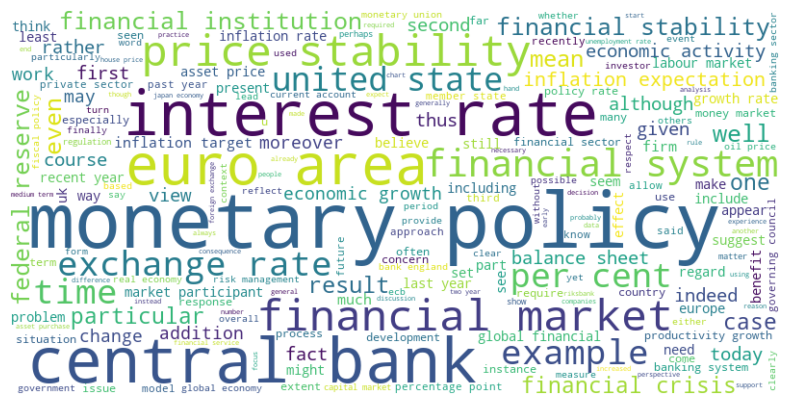

In [49]:
# Concatenate all the text in the 'clean_text' column into one large string
text = ' '.join(speech_13['clean_text'].astype(str))

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

# Display the generated word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Do not display axes for visual appeal
plt.show()

In [50]:
# Subset the data to only show BOE speeches, from 1992 - 2022, in English

# Step 1: Define the conditions
condition1 = speech_13['central_bank'] == 'Bank of England'
condition2 = speech_13['language'] == 'en'
condition3 = speech_13['date'].dt.year >= 1992
condition4 = speech_13['date'].dt.year <= 2022

# Step 2: Combine the conditions
combined_conditions = condition1 & condition2 & condition3 & condition4

# Step 3: Filter the DataFrame based on the combined conditions
speech_blob_1 = speech_13[combined_conditions]

# Step 4: Save as CSV
speech_blob_1.to_csv('speech_blob_1.csv', index=False)

The speech data suitable for Textblob analysis has been successfully saved as speech_blob_1.csv.

In [51]:
# Verify the count of speeches in the speech_blob_1 dataframe
speech_blob_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1209 entries, 4961 to 6169
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   reference     1209 non-null   object        
 1   country       1209 non-null   object        
 2   date          1209 non-null   datetime64[ns]
 3   title         1209 non-null   object        
 4   author        1209 non-null   object        
 5   is_gov        1209 non-null   bool          
 6   text          1209 non-null   object        
 7   Body          1209 non-null   object        
 8   central_bank  1209 non-null   object        
 9   year          1209 non-null   int32         
 10  language      1209 non-null   object        
 11  clean_text    1209 non-null   object        
dtypes: bool(1), datetime64[ns](1), int32(1), object(9)
memory usage: 109.8+ KB


Similar to the Vader analysis' subsetted data, there are 1209 entries which captures all data relating to BOE, between 1992 and 2022. 

# 6. Further final summarisation and exploration of dataset

## 6a. Identify Count and Frequency of BOE speeches by month (between 1992 and 2022)

### Count of BOE speeches by month

In [52]:
# Step 1: Filter for 'Bank of England'
boe_speeches = speech_13[speech_13['central_bank'] == 'Bank of England']

# Step 2: Filter for dates between 1992 and 2022 inclusive
boe_speeches = boe_speeches[(boe_speeches['date'] >= '1992-01-01') & (boe_speeches['date'] <= '2022-12-31')]

# Step 3: Extract year and month, and combine them into a new 'year_month' column
boe_speeches['year_month'] = boe_speeches['date'].dt.to_period('M').dt.to_timestamp()

# Step 4: Create 'month_string' column for visibility
boe_speeches['month_string'] = boe_speeches['date'].dt.strftime('%B %Y')

# Step 5: Group by the new 'year_month' column, and count speeches. 
# Include 'month_string' in the groupby to ensure it's carried into the final DataFrame
speeches_counts = boe_speeches.groupby(['year_month', 'month_string']).size().reset_index(name='count')

# Keeping 'year_month' in the final DataFrame
speeches_counts = speeches_counts[['year_month', 'month_string', 'count']]

# Exporting to CSV - make sure to specify the full path if needed
file_path = 'boe_count_by_month_and_year.csv'
speeches_counts.to_csv(file_path, index=False)

print("The table has been exported as a CSV file to:", file_path)

print(speeches_counts)

The table has been exported as a CSV file to: boe_count_by_month_and_year.csv
    year_month    month_string  count
0   1998-09-01  September 1998      1
1   1998-10-01    October 1998      2
2   1998-11-01   November 1998      3
3   1998-12-01   December 1998      2
4   1999-01-01    January 1999      2
..         ...             ...    ...
267 2022-05-01        May 2022      7
268 2022-06-01       June 2022      6
269 2022-07-01       July 2022      9
270 2022-09-01  September 2022      6
271 2022-10-01    October 2022      6

[272 rows x 3 columns]


### Average number of days between BOE speeches, by year

In [53]:
# Calculate average number of days between BoE speeches by year
# Step 1: Filter for 'Bank of England'
boe_speeches = speech_13[speech_13['central_bank'] == 'Bank of England']

# Step 2: Sort the DataFrame by date
boe_speeches_sorted = boe_speeches.sort_values(by='date')

# Step 3: Calculate differences between consecutive speech dates
boe_speeches_sorted['date_diff'] = boe_speeches_sorted['date'].diff().dt.days

# Step 4: Extract the year from the date
boe_speeches_sorted['year'] = boe_speeches_sorted['date'].dt.year

# Step 5: Group by year and calculate the average difference
average_frequency_per_year = boe_speeches_sorted.groupby('year')['date_diff'].mean().round(2)

print("Average frequency of speeches per year (in days):")
print(average_frequency_per_year)

# Convert the Series to a DataFrame for easy CSV export
average_frequency_df = average_frequency_per_year.reset_index()

# Naming the columns explicitly for clarity
average_frequency_df.columns = ['Year', 'Average_Days_Between_Speeches']

# Export the DataFrame to a CSV file
average_frequency_df.to_csv('average_frequency_boe.csv', index=False)

Average frequency of speeches per year (in days):
year
1998    13.00
1999    12.23
2000     9.64
2001     9.62
2002    11.93
2003    18.11
2004    13.46
2005    13.04
2006    11.32
2007    10.20
2008     9.28
2009     7.75
2010     7.93
2011     5.40
2012     5.74
2013     6.08
2014     5.00
2015     4.60
2016     4.86
2017     5.97
2018     5.85
2019     4.74
2020     6.14
2021     5.92
2022     6.62
Name: date_diff, dtype: float64


## 6b. Calculate wordcount for each speech

In [54]:
# First, create a new DataFrame 'speech_14' by copying 'speech_13'
speech_14 = speech_13.copy()

# Create a new column 'wordcount' to count the words in each 'text' row
speech_14['wordcount'] = speech_14['text'].apply(lambda x: len(str(x).split()))

# Save 'speech_14' as a CSV file
file_path = 'speech_14.csv'  # Specify your desired path
speech_14.to_csv(file_path, index=False)

print(f"'speech_14' saved to {file_path}")

'speech_14' saved to speech_14.csv


## 6c. Useful code to analyse entire speech text for specific rows

The below code is useful to view the entire content of a specific speech, if required.

In [55]:
# Temporarily adjust the display.max_colwidth option
pd.set_option('display.max_colwidth', None)

reference_id = 'r990424a_ECB'  # Replace with the actual reference ID

# Filter the DataFrame for the row with the specific reference ID
specific_row = speech_14[speech_14['reference'] == reference_id]

# Display the specific row and all its contents
print(specific_row)

        reference    country       date  \
986  r990424a_ECB  Euro Area 1999-04-24   

                                                       title     author  \
986  The Euro: Europe's new currency and the role of the ECB  Francisco   

     is_gov  \
986   False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           